# Using TopOMetry for document embedding

    This tutorial reproduces an UMAP example on the [20 newsgroups dataset](http://qwone.com/~jason/20Newsgroups/) for document embedding, and compares its results to those of TopOMetry models. The 20 newsgroups dataset is a collection of forum posts, labelled by topic. The task here is to represent this high-dimensional information in a comprehensive visualization in which news within the same topic end up close together, and different topics get separated from each other. By the end of this tutorial, we'll see TopOMetry recoveries a lot of substructure that was missed by UMAP. This is possible by first harnessing topological information, and then using different layout methods to visualize and interpret it.

Load required libraries:

In [1]:
import pandas as pd
import umap
import umap.plot

# Used to get the data
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

# Some plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
from bokeh.plotting import show, save, output_notebook, output_file
from bokeh.resources import INLINE
output_notebook(resources=INLINE)

Loading BokehJS ...

Download data:

In [2]:
%%time
dataset = fetch_20newsgroups(subset='all',
                             shuffle=True, random_state=42)

CPU times: user 261 ms, sys: 46.7 ms, total: 307 ms
Wall time: 391 ms


In [3]:
print(f'{len(dataset.data)} documents')
print(f'{len(dataset.target_names)} categories')

18846 documents
20 categories


This data contains 18846 documents spanning 20 categories. These categories are:

In [4]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

 We can print some of our news to get an idea of what we're dealing with.

In [5]:
for idx, document in enumerate(dataset.data[:3]):
    category = dataset.target_names[dataset.target[idx]]

    print(f'Category: {category}')
    print('---------------------------')
    # Print the first 500 characters of the post
    print(document[:500])
    print('---------------------------')

Category: rec.sport.hockey
---------------------------
From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killin
---------------------------
Category: comp.sys.ibm.pc.hardware
---------------------------
From: mblawson@midway.ecn.uoknor.edu (Matthew B Lawson)
Subject: Which high-performance VLB video card?
Summary: Seek recommendations for VLB video card
Nntp-Posting-Host: midway.ecn.uoknor.edu
Organization: Engineering Computer Network, University of Oklahoma, Norman, OK, USA
Keywords: orchid, stealth, vlb
Lines: 21

  My brother is in the market for

In [6]:
category_labels = [dataset.target_names[x] for x in dataset.target]
hover_df = pd.DataFrame(category_labels, columns=['category'])

#### Representing texts as a matrix

Here, we'll use the [bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model) approach. For this, we'll count how many times each word appeared in each document, and create a matrix of word frequency per document. This will allow us to quantitatively represent these texts. Such task is done using scikit-learn CountVectorizer. 

In [7]:
vectorizer = CountVectorizer(min_df=5, stop_words='english')
word_doc_matrix = vectorizer.fit_transform(dataset.data)

 Next, we feed this matrix to UMAP.

In [8]:
%%time
embedding = umap.UMAP(n_components=2, metric='hellinger').fit(word_doc_matrix)

CPU times: user 3min 27s, sys: 5.39 s, total: 3min 33s
Wall time: 1min 7s


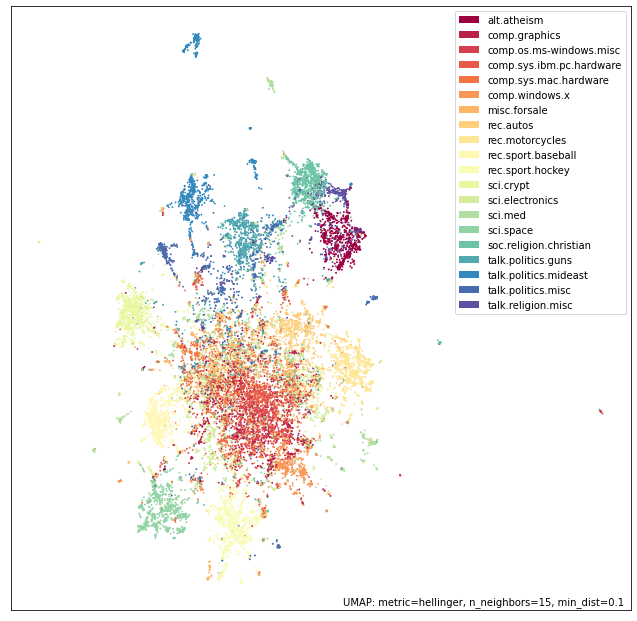

In [9]:
f = umap.plot.points(embedding, labels=hover_df['category'])

 UMAP performs really well! It sucessfully separates main categories and topics (i.e. eletronics, religion, politics and sports). However, it does not add much new insight on top of the previously known categories: note how the 'main blob' representing eletronic and computational topics becomes overcrowded by poorly-defined structure.

## Using TopOMetry

Just like in the digits tutorial, we'll create a TopOGraph object to start our analysis. Parameters can be set at this time but also easily set later.

In [10]:
import topo as tp

# Start up the TopOGraph
tg = tp.TopOGraph(n_jobs=12, n_eigs=30, # set parameters at start
                         backend='nmslib')
tg.verbosity=1     # set parameter later
tg.fit(word_doc_matrix)     # feed the bag-of-words matrix

db_diff_graph = tg.transform() # learns a similarity graph

# Minimize divergence between the diffusion basis and diffusion graph
emb_db_diff_map = tg.MAP() # by default computes a spectral initialisation

Computing neighborhood graph...
 Base kNN graph computed in 8.535140 (sec)
Building topological basis...using diffusion model.


/home/davi/.local/lib/python3.9/site-packages/kneed/knee_locator.py:304: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")


 Topological basis fitted with multiscale self-adaptive diffusion maps in 4.803387 (sec)
    Building topological graph...
     Topological `diff` graph extracted in = 1.875015 (sec)
         Spectral layout not stored at TopOGraph.SpecLayout. Trying to compute...
         Optimized MAP embedding in = 24.982344 (sec)


Please note that, for the simplicity of this tutorial, we want to keep the figure style constant. Thus, we'll continue to use the UMAP plotting function, and will only update the coordinates of the points so that they correspond to those we just computed with TopOMetry.

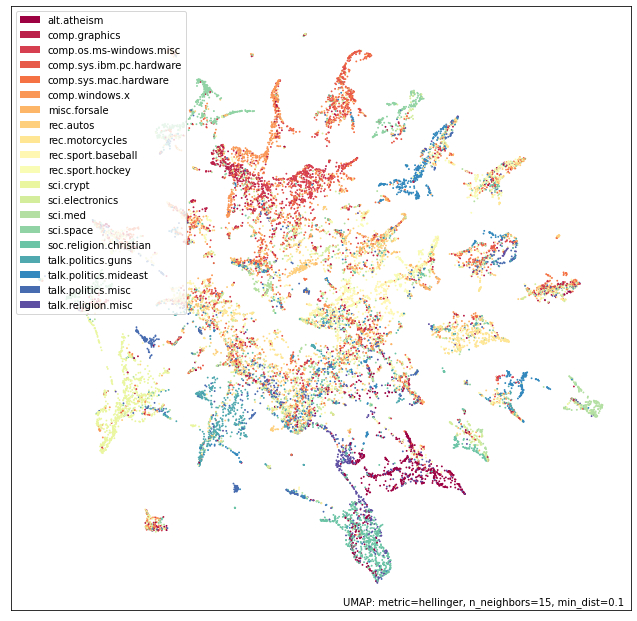

In [11]:
embedding_topometry = embedding
embedding_topometry.embedding_ = emb_db_diff_map
t = umap.plot.points(embedding_topometry, labels=hover_df['category'])

Beyond separating known categories, this plot gives us insights in their relationships (i.g. atheism and religion topics connected at the lower left), this plot tells us more about the poorly separated topics. Apparently, these categories hold defined subcategories within them.

 Now let's try with other embedding methods:

In [12]:
emb_db_pacmap = tg.PaCMAP(distance='angular')
emb_db_trimap = tg.TriMAP()
emb_db_tsne = tg.tSNE()
emb_db_ncvis = tg.NCVis()
emb_db_mde = tg.MDE()

         Obtained PaCMAP embedding in = 90.969480 (sec)
         Obtained TriMAP embedding in = 78.697911 (sec)
         Obtained tSNE embedding in = 117.070226 (sec)
         Obtained NCVis embedding in = 7.062480 (sec)
         Obtained MDE embedding in = 56.139197 (sec)


PaCMAP

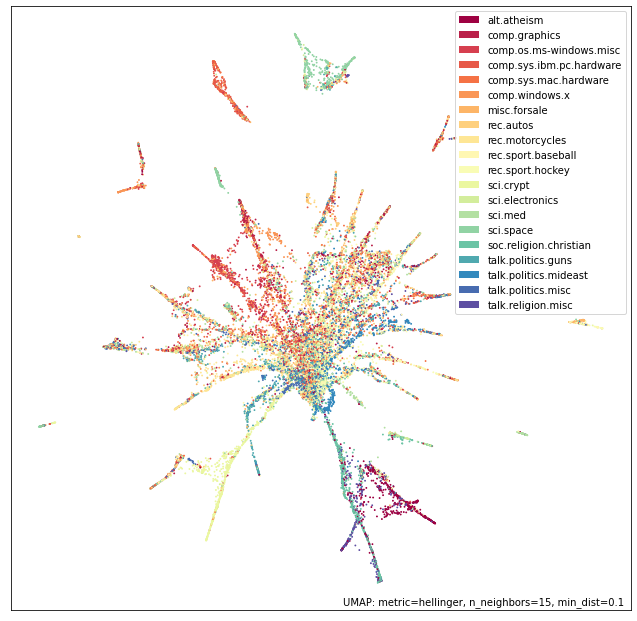

In [13]:
embedding_topometry = embedding
embedding_topometry.embedding_ = emb_db_pacmap
t = umap.plot.points(embedding_topometry, labels=hover_df['category'])

TriMAP

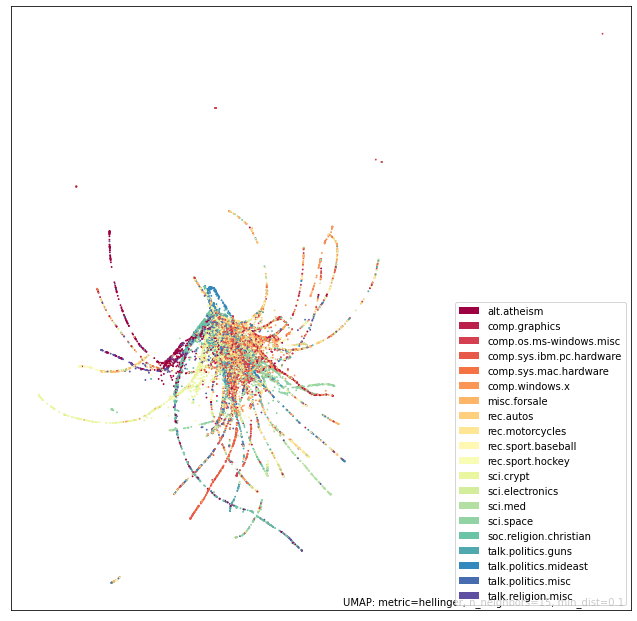

In [14]:
embedding_topometry = embedding
embedding_topometry.embedding_ = emb_db_trimap
t = umap.plot.points(embedding_topometry, labels=hover_df['category'])

tSNE

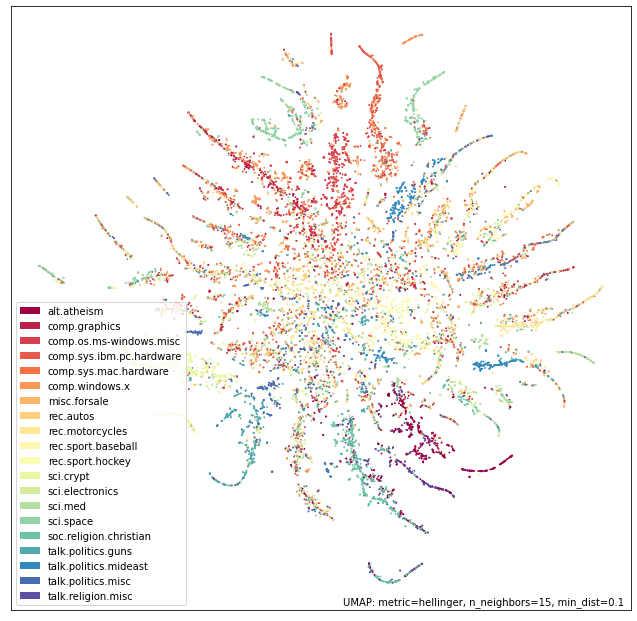

In [15]:
embedding_topometry = embedding
embedding_topometry.embedding_ = emb_db_tsne
t = umap.plot.points(embedding_topometry, labels=hover_df['category'])

NCVis

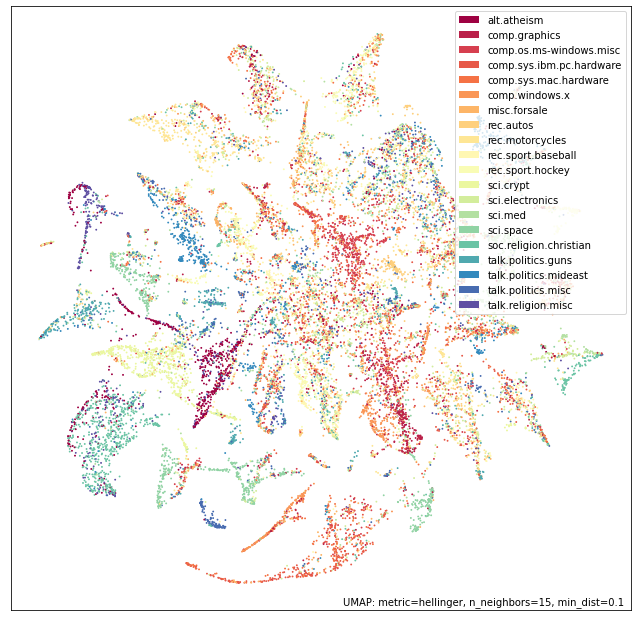

In [16]:
embedding_topometry = embedding
embedding_topometry.embedding_ = emb_db_ncvis
t = umap.plot.points(embedding_topometry, labels=hover_df['category'])

MDE

         Obtained MDE embedding in = 18.463227 (sec)


  0%|          | 0/6 [00:00<?, ?it/s]

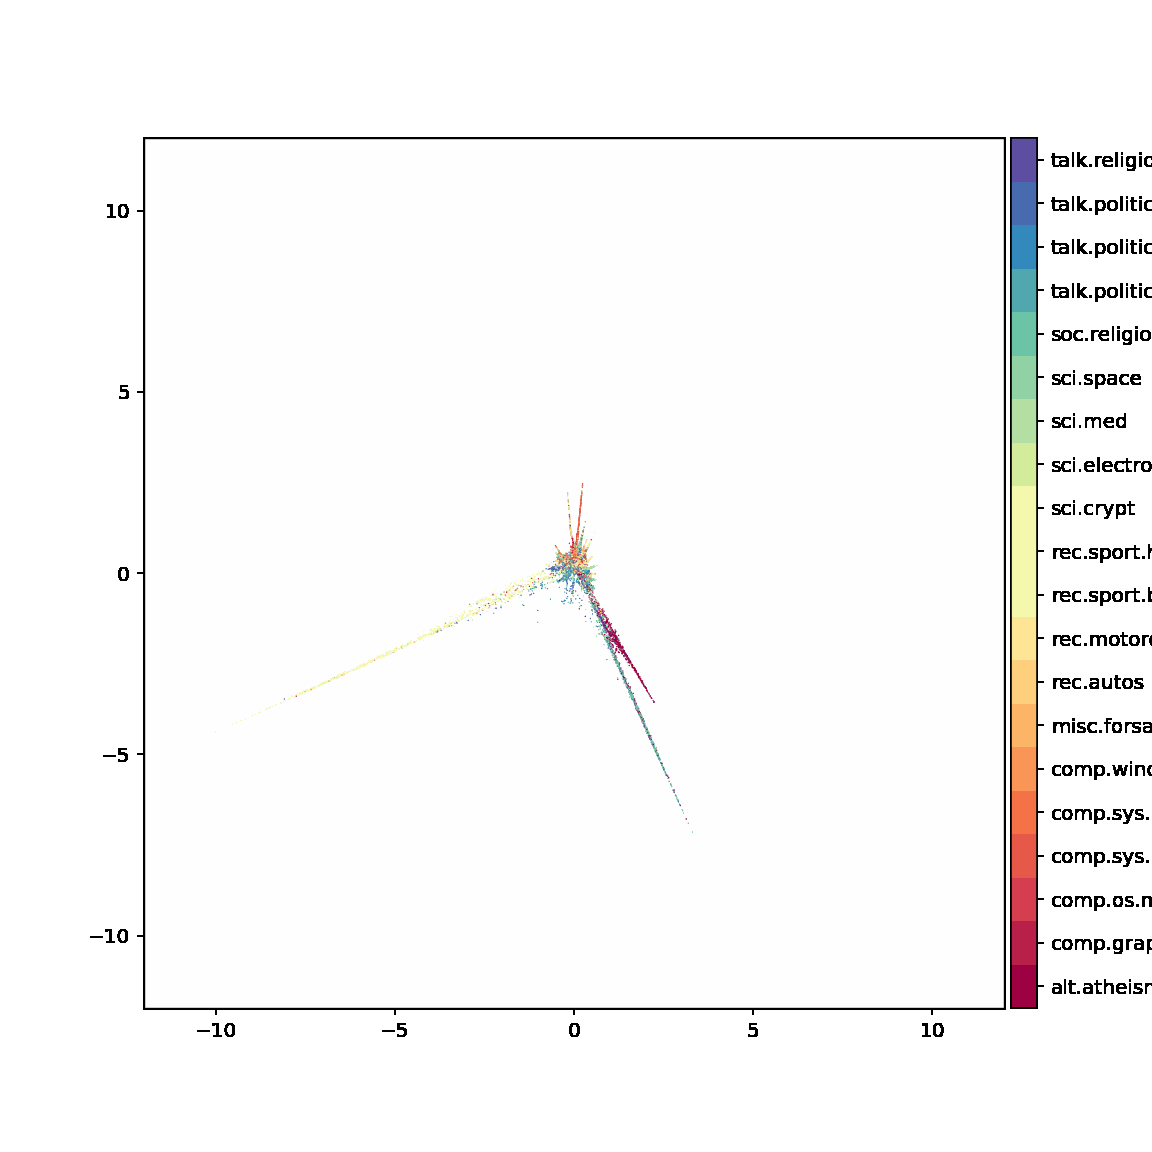

In [24]:
db_diff_mde = tg.MDE(snapshot_every=5, mem_size=1,  n_epochs=6000, init=tg.SpecLayout)
tg.MDE_problem.play(savepath= '20NewsGroups_db_diff_MDE.gif', marker_size=0.5, color_by=hover_df['category'],  figsize_inches=(8,8), axis_limits=[-12, 12])

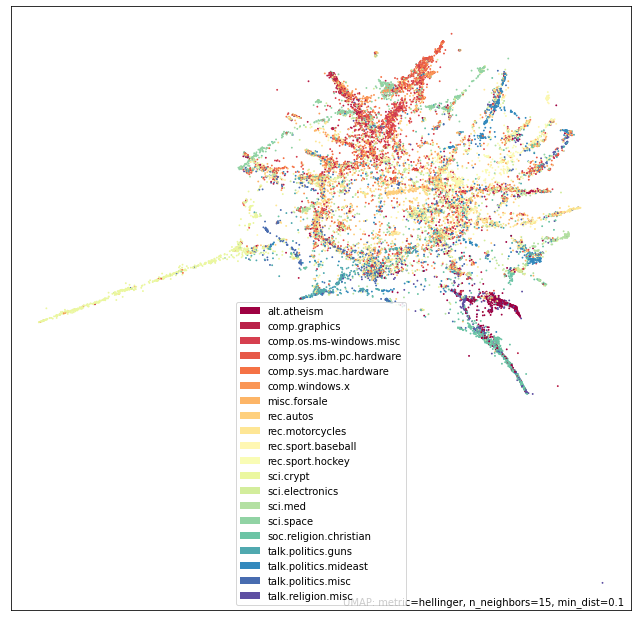

In [25]:
embedding_topometry = embedding
embedding_topometry.embedding_ = db_diff_mde
t = umap.plot.points(embedding_topometry, labels=hover_df['category'])

As we can see, with TopOMetry it is possible to uncover a much more elaborate visualization of the data geometry. In this case, a central root of texts containing mostly common words and distributed across many different topics - as we walk away from this homogenous mass in the geometry of this dataset, neighborhood paths become more specific and restrited to single-topics. Plausably, the edges of these spikes should contain the texts with most heterogeneity across the dataset, rendering them good examples for specific language of a specific field. Similarly, words enriched at the central blob could be striped off the dataset for a downstram, more refined analysis containing heterogeneity-driving words.
We do not claim any of particular model to perform better or worse beforehand - instead, seeing how different algorithms deal with the heterogenous structure of data allows us to elaborate better insights from data. In this case, by using only 1 of 9 available models and exploring 6 different layouts, we could generate several hypotheses. 

Additionally, we can score these embeddings to see how they perform. For this, please see the next tutorial.